In [39]:
import numpy as np

import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import scipy.stats as sc
from scipy.cluster.hierarchy import linkage, cut_tree, leaves_list

from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression, ElasticNet
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

import os

In [48]:
def elapsedtime_to_sec(el):
    tab = el.split(":")
    return float(tab[0])*60+float(tab[1])
#because x264 output is "m:s", where m is the number of minutes and s the number of seconds 

res_dir = "../../data/res_ugc/"

v_names = sorted(os.listdir(res_dir)) # so we keep the same ids between two launches

listVideo = []

for v in v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    assert data.shape == (201,36) or data.shape == (201,34), v
    listVideo.append(data)

input_sizes = pd.read_csv("../../data/sizes.csv", delimiter=',').set_index('name')
#input_sizes.columns = ['path','name','size']
input_sizes

for i in range(len(listVideo)):
    input_video_size = input_sizes.loc[v_names[i][:-4]]['size']
    listVideo[i]['crate'] = listVideo[i]['size']/input_video_size

In [49]:
#our variable of interest
predDimension = "size"

for i in range(len(listVideo)):
    sizes = listVideo[i][predDimension]
    ind = sorted(range(len(sizes)), key=lambda k: sizes[k])
    listVideo[i]['ranking'] = ind

# Introduction

In [50]:
ratio_placebo_ultrafast = []
for j in range(len(listVideo)):
    ratio_placebo_ultrafast.append(listVideo[j].loc[0][predDimension]/listVideo[j].loc[10][predDimension])
print(np.mean(ratio_placebo_ultrafast))

1.9595993569115207


In [51]:
listVideo[0]

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,elapsedtime,cpu,frames,fps,kbs,ssim,ssimdb,etime,crate,ranking
0,1,0,1,0:0:0,0:0,dia,0,0,16,0,...,0:02.14,434,600,375.22,161.07,NaN,NaN,2.14,0.000216,166
1,101,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,0:03.40,734,600,217.07,93.57,NaN,NaN,3.40,0.000125,164
2,102,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,0:02.71,739,600,293.42,63.87,NaN,NaN,2.71,0.000086,169
3,103,1,2,0:0:0,0x3:0x3,umh,6,1,16,1,...,0:02.78,858,600,276.79,65.37,NaN,NaN,2.78,0.000088,165
4,104,1,16,1:0:0,0x3:0x113,hex,6,1,24,1,...,0:02.74,699,600,287.79,87.27,NaN,NaN,2.74,0.000117,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,97,1,2,1:0:0,0x3:0x113,hex,4,1,16,0,...,0:03.01,716,600,254.20,73.20,NaN,NaN,3.01,0.000098,7
197,98,1,2,0:0:0,0x3:0x113,hex,4,0,24,0,...,0:02.88,644,600,269.38,78.21,NaN,NaN,2.88,0.000105,148
198,99,1,5,1:0:0,0x3:0x113,hex,6,1,16,1,...,0:02.92,927,600,263.64,71.19,NaN,NaN,2.92,0.000095,147
199,100,0,3,0:0:0,0x113:0x113,hex,6,1,16,1,...,0:02.89,685,600,267.21,93.51,NaN,NaN,2.89,0.000125,188


In [52]:
np.mean(listVideo[np.argmax([np.mean(vid["etime"]) for vid in listVideo])]["etime"])
#v_names[np.argmax([np.mean(vid["etime"]) for vid in listVideo])]

188.70930348258707

# RQ1 - Input sensitivity

## RQ1.1 - Do the same options have the same effect on all inputs?

In [53]:
nbVideos = len(listVideo)
corrSpearman= [[0 for x in range(nbVideos)] for y in range(nbVideos)]

for i in range(nbVideos):
    for j in range(nbVideos):
        if (i == j):
            corrSpearman[i][j] = 1
        else:
            corrSpearman[i][j] = sc.spearmanr(listVideo[i][predDimension],
                                            listVideo[j][predDimension]).correlation

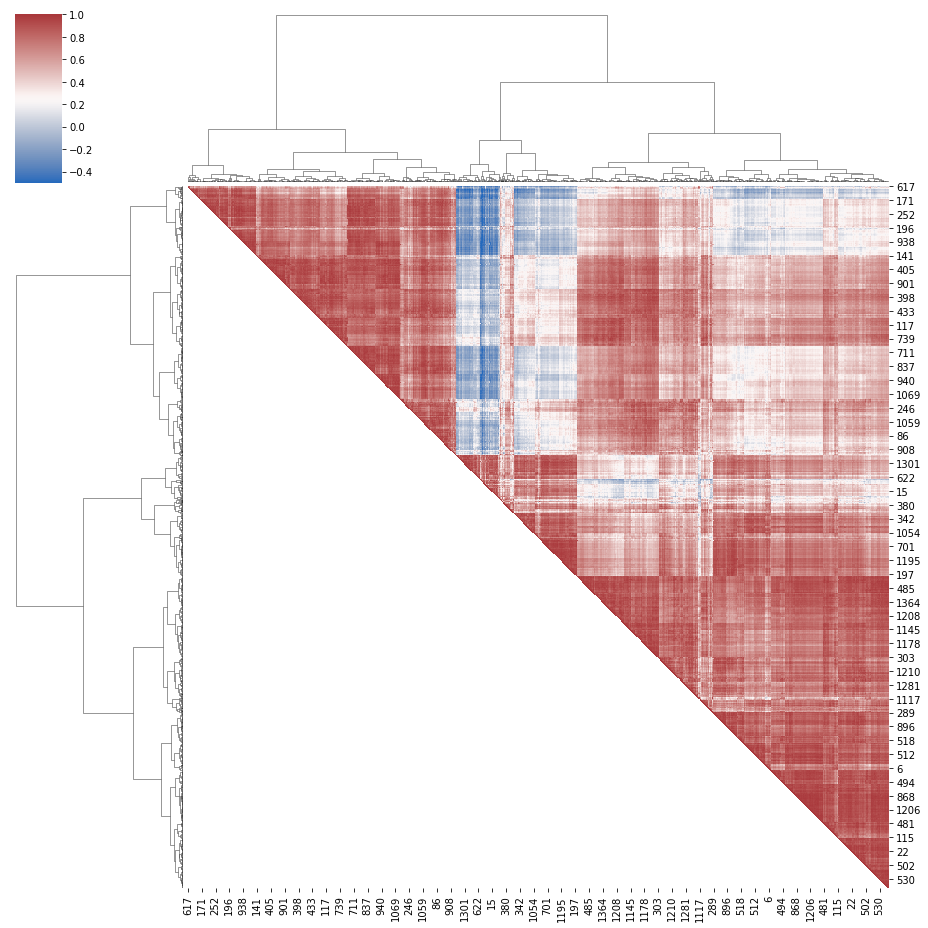

In [54]:
result_dir = "../../results/"

def plot_correlationmatrix_dendogram(corr, img_name, ticks, method= 'ward', div=False):

    df = pd.DataFrame(corr)
    
    # group the videos
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(nbVideos):
        for j in range(nbVideos):
            if i>j:
                mask[order[i]][order[j]] = True
    
    sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), cbar_kws={"ticks":ticks}, vmin =-0.5)
    plt.savefig(result_dir+img_name)
    plt.show()
    
    return cut_tree(links, n_clusters = 3)

group_no_ordered = plot_correlationmatrix_dendogram(corrSpearman, 
                                 "corrmatrix-ugc-dendo-Spearman-" + predDimension + ".pdf",
                                 [k/5 for k in np.arange(-10,10,1)], method='ward')

In [55]:
map_group = [1, 2, 0]

def f(gr):
    return map_group[int(gr)]

groups = np.array([*map(f, group_no_ordered)],int)

sum(groups==0)
sum(groups==1)
sum(groups==2)

525

In [56]:
corrDescription = [corrSpearman[i][j] for i in range(nbVideos) for j in range(nbVideos) if i >j]
pd.Series(corrDescription).describe()

count    936396.000000
mean          0.569145
std           0.287539
min          -0.693836
25%           0.398135
50%           0.632591
75%           0.796241
max           0.997228
dtype: float64

In [11]:
def plot_simple_correlationmatrix_dendogram(corr, img_name, ticks, id_names, method='ward'):

    df = pd.DataFrame(corr)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(shortnbVideos):
        for j in range(shortnbVideos):
            if i>j:
                mask[i][j] = True
    fig = plt.figure(figsize=(10, 8.5))
    ax = fig.add_subplot(1,1,1)
    sns.heatmap(df, cmap="vlag", mask=mask,
               linewidths=.75, cbar_kws={"ticks":ticks})
    plt.yticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.xticks(np.arange(0,len(id_names),1)+0.5, id_names)
    plt.savefig(result_dir+img_name)
    plt.show()

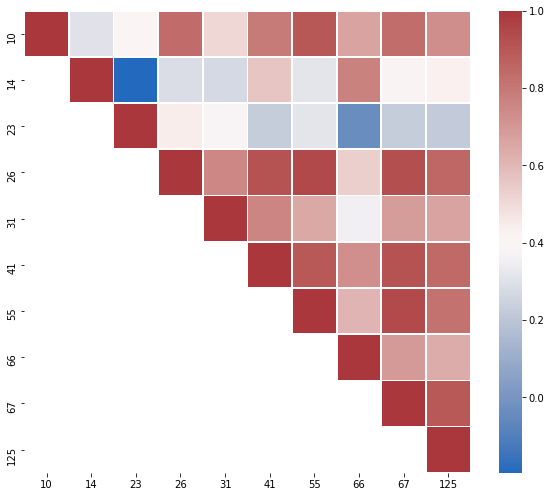

In [12]:
id_short = [10, 14, 23, 26, 31, 41, 55, 66, 67, 125]
short_v_names = [v_names[k] for k in id_short]

shortlistVideo = []
for v in short_v_names:
    data = pd.read_table(res_dir+v, delimiter = ',')
    data['etime'] = [*map(elapsedtime_to_sec, data['elapsedtime'])]
    input_video_size = input_sizes.loc[v[:-4]]['size']
    data['crate'] = data['size']/input_video_size
    shortlistVideo.append(data)
    
shortnbVideos = len(shortlistVideo)

shortcorrSpearman= [[0 for x in range(shortnbVideos)] for y in range(shortnbVideos)]


for i in range(shortnbVideos):
    for j in range(shortnbVideos):
        if (i == j):
            shortcorrSpearman[i][j] = 1
        else:
            shortcorrSpearman[i][j] = sc.spearmanr(listVideo[id_short[i]][predDimension],listVideo[id_short[j]][predDimension]).correlation

plot_simple_correlationmatrix_dendogram(shortcorrSpearman, 
                     "../../results/corrmatrix-ugc-dendo-Spearman-short-" + predDimension + ".png", 
                     [k/5 for k in np.arange(-10,10,1)],
                                      id_short)

# RQ1-2

### Shortlist

In [13]:
id_short

[10, 14, 23, 26, 31, 41, 55, 66, 67, 125]

In [14]:
shortlistVideo[0] # video 10

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,systemtime,elapsedtime,cpu,frames,fps,kbs,ssim,ssimdb,etime,crate
0,1,0,1,0:0:0,0:0,dia,0,0,16,0,...,0.92,0:01.75,549,480,379.18,7675.34,NaN,NaN,1.75,0.012852
1,101,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,1.56,0:04.08,770,480,137.35,2722.25,NaN,NaN,4.08,0.004558
2,102,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,1.58,0:03.04,905,480,194.98,3179.35,NaN,NaN,3.04,0.005324
3,103,1,2,0:0:0,0x3:0x3,umh,6,1,16,1,...,1.37,0:02.89,1181,480,206.63,3142.93,NaN,NaN,2.89,0.005263
4,104,1,16,1:0:0,0x3:0x113,hex,6,1,24,1,...,1.41,0:03.29,1249,480,176.69,2579.38,NaN,NaN,3.29,0.004319
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,97,1,2,1:0:0,0x3:0x113,hex,4,1,16,0,...,1.67,0:03.55,745,480,160.70,2747.42,NaN,NaN,3.55,0.004600
197,98,1,2,0:0:0,0x3:0x113,hex,4,0,24,0,...,1.59,0:03.06,766,480,192.69,2805.80,NaN,NaN,3.06,0.004698
198,99,1,5,1:0:0,0x3:0x113,hex,6,1,16,1,...,1.42,0:03.45,996,480,166.61,2582.37,NaN,NaN,3.45,0.004324
199,100,0,3,0:0:0,0x113:0x113,hex,6,1,16,1,...,1.56,0:02.76,1022,480,218.91,3379.49,NaN,NaN,2.76,0.005659


In [15]:
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

to_keep = [k for k in listFeatures]
to_keep.append(predDimension)

categorial = ['analyse', 'me', 'direct']

def compute_Importances(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
        
    listImportances = []

    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')

        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                if col not in [predDimension,'ranking']:
                    df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                    arr_col = np.array(df[col],int)
                    arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                    df[col] = arr_col

        clf = RandomForestRegressor(n_estimators=200)
        X = df.drop([predDimension],axis=1)
        y = df[predDimension]
        clf.fit(X,y)

        listImportances.append(clf.feature_importances_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').transpose().drop(['open_gop','qpmax'],axis=1)
    return res

res = compute_Importances(shortlistVideo, id_short)
res.to_csv("../../results/shortlist_features_importances"+predDimension+".csv")

### Boxplot

In [16]:
res = compute_Importances(listVideo)

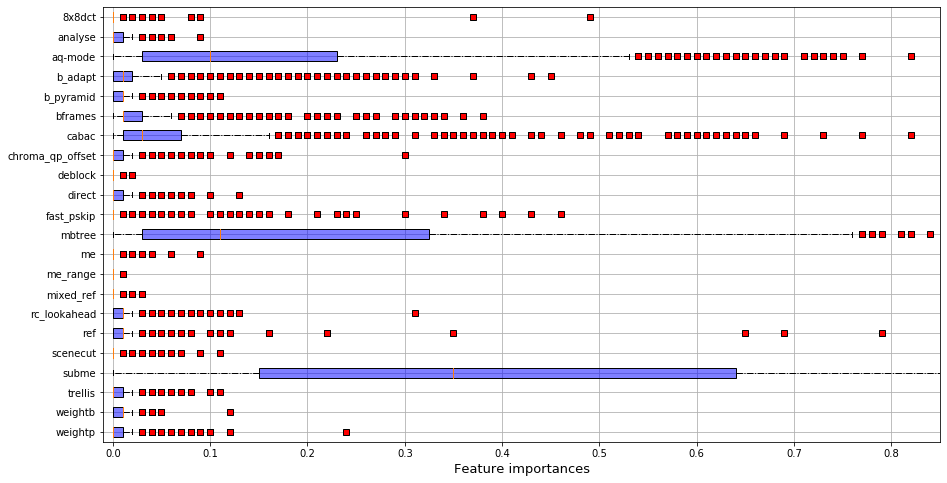

In [17]:
def boxplot_imp(res, xlim = None, criteria = 'max', name = None):
    if criteria == 'max':
        listImp = [(np.percentile(res[col],75), res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'range':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[0])
    elif criteria == 'name':
        listImp = [(np.abs(np.percentile(res[col],75)-np.percentile(res[col],25)),res[col], col) 
                   for col in res.columns]
        listImp.sort(key=lambda tup: tup[2], reverse=True)

    red_square = dict(markerfacecolor='r', marker='s')
    plt.figure(figsize=(15,8))
    plt.grid()
    plt.boxplot([l[1] for l in listImp], flierprops=red_square, 
              vert=False, patch_artist=True, #widths=0.25,
              boxprops=dict(facecolor=(0,0,1,0.5),linewidth=1,edgecolor='k'),
              whiskerprops = dict(linestyle='-.',linewidth=1.0, color='black'))
    plt.xlabel('Feature importances',size=13)
    if xlim:
        plt.xlim(xlim)
    plt.yticks(range(1, len(listImp) + 1), [l[2] for l in listImp])
    if name:
        plt.savefig(name)
    plt.show()
    
boxplot_imp(res, xlim = (-0.01,0.85),
            criteria = 'name', 
            name = "../../results/boxplot_features_imp_rf_"+predDimension+".png")

### Regression

In [18]:
def compute_poly(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listImportances = []
    
    #listFeatures = ['subme','aq-mode','mbtree','cabac']
    
    to_keep = [k for k in listFeatures]
    to_keep.append(predDimension)
    
    names = listFeatures
    final_names = []
    final_names.append('constant')
    for n in names:
        final_names.append(n)
    for n1 in range(len(names)):
        for n2 in range(len(names)):
            if n1>=n2:
                final_names.append(str(names[n1])+'*'+str(names[n2]))
    
    for id_video in range(len(listVid)):

        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        df['deblock'] =[int(val[0]) for val in df['deblock']]

        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col

        clf = LinearRegression()
        X = df.drop([predDimension],axis=1)

        y = df[predDimension]
        #poly = PolynomialFeatures(degree=1, interaction_only = False, include_bias = True)    
        #X_interact = pd.DataFrame(poly.fit_transform(X))#, columns=final_names)
        #kept_names = ['subme','aq-mode','mbtree','cabac','cabac*mbtree','aq-mode*subme','cabac*subme']
        clf.fit(X,y)
        listImportances.append(clf.coef_)

    res = pd.DataFrame({'features' : listFeatures})

    cs = 100

    for id_video in range(len(listImportances)):
        res['video_'+str(id_short[id_video])] = np.round(cs*listImportances[id_video])/cs

    res = res.set_index('features').drop(['open_gop','qpmax']).transpose()
    return res

res = compute_poly(listVideo)
res.to_csv("../../results/list_features_importances_poly_"+predDimension+".csv")
res

features,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,8x8dct,...,bframes,b_pyramid,b_adapt,direct,weightb,weightp,scenecut,rc_lookahead,mbtree,aq-mode
video_0,-0.18,-0.00,0.06,-0.07,-0.07,-0.03,-0.03,-0.06,-0.09,-0.01,...,-0.05,0.16,0.05,-0.02,-0.18,-0.13,-0.15,-0.01,-0.05,0.00
video_1,-0.25,-0.15,-0.04,-0.04,-0.17,-0.28,0.00,-0.04,0.04,-0.19,...,-0.09,0.07,0.04,-0.01,-0.14,-0.06,0.03,-0.01,0.13,-0.43
video_2,-0.19,0.00,-0.05,-0.03,-0.07,-0.30,-0.05,-0.03,0.03,-0.11,...,-0.07,-0.09,0.06,-0.02,-0.34,0.04,-0.04,0.05,-0.02,-0.27
video_3,-0.15,0.07,-0.09,-0.04,-0.06,-0.32,-0.01,-0.05,0.11,-0.17,...,-0.06,-0.17,0.12,-0.01,-0.33,0.03,-0.01,0.05,0.27,-0.43
video_4,-0.14,0.02,-0.05,-0.00,-0.10,-0.26,-0.01,-0.04,0.06,-0.20,...,-0.10,-0.00,0.13,-0.04,-0.33,0.01,0.01,0.03,0.11,-0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
video_1078,-0.16,0.05,-0.09,-0.05,-0.06,-0.33,-0.01,-0.06,0.05,-0.20,...,-0.04,-0.06,0.19,-0.02,-0.36,0.06,-0.04,0.11,-0.13,-0.29
video_1079,-0.06,0.11,-0.13,-0.08,-0.05,-0.37,-0.02,-0.06,0.11,-0.21,...,-0.08,-0.05,0.08,-0.00,-0.33,0.03,0.00,0.06,0.42,-0.47
video_1080,-0.14,0.07,-0.12,-0.06,-0.06,-0.41,-0.01,-0.06,0.10,-0.21,...,-0.07,-0.08,0.16,0.00,-0.31,0.02,0.00,0.05,0.09,-0.35
video_1081,-0.44,0.01,-0.07,-0.05,-0.10,-0.12,-0.00,-0.02,0.10,-0.04,...,-0.07,0.12,-0.06,0.02,0.03,0.03,0.17,0.05,-0.79,0.46


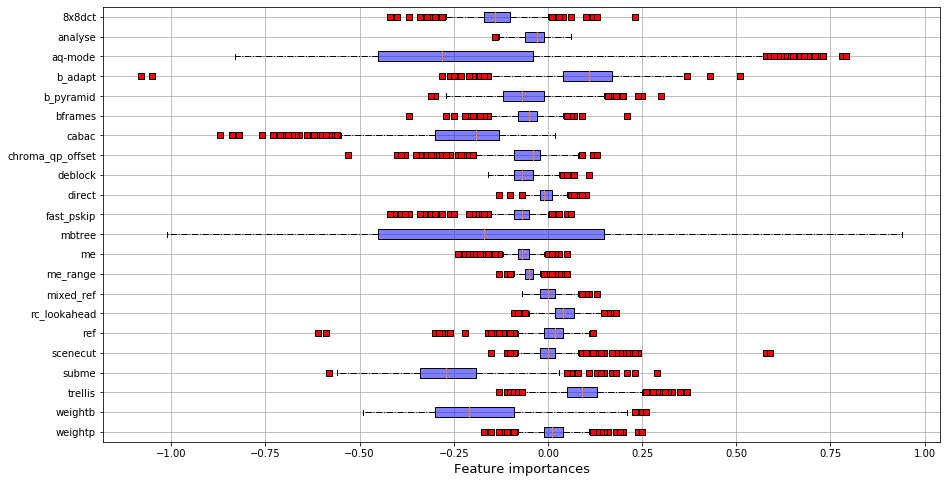

In [19]:
boxplot_imp(res, criteria ='name', name ="../../results/boxplot_features_imp_linear_"+predDimension+".png")

## RQ1.3 - Ranking and accuracy comparison

### A- Accuracy

In [20]:
def compute_accuracies(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
        
    listAccuracies = []

    for id_video in range(len(listVid)):

        acc_vid = []
        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        
        df['deblock'] =[int(val[0]) for val in df['deblock']]
        
        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        X = df.drop([predDimension], axis=1)
        y = df[predDimension]
        
        for i in range(5):
            
            clf = RandomForestRegressor(n_estimators=200)
            
            X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

            clf.fit(X_train, y_train)

            y_pred = clf.predict(X_test)
            
            acc_vid.append(np.mean(np.abs((y_test - y_pred) / (y_test + 1e-5)))*100)

        listAccuracies.append(np.mean(acc_vid))

    res = pd.DataFrame({ 'inputs' : v_names, 
                         'accuracy' : listAccuracies})

    return res

res = compute_accuracies(listVideo)
res.to_csv("../../results/shortlist_accuracies"+predDimension+".csv")

In [21]:
pd.Series(res['accuracy']).describe()

count     1083.000000
mean       142.014332
std        829.480511
min          8.124965
25%         40.026418
50%         58.235793
75%         95.867101
max      22329.657875
Name: accuracy, dtype: float64

In [22]:
df = listVideo[1][to_keep].replace(to_replace ="None",value='0')

df['deblock'] =[int(val[0]) for val in df['deblock']]

for col in df.columns:
    if col not in categorial:
        arr_col = np.array(df[col],int)
        arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
        df[col] = arr_col
    else:
        df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
        arr_col = np.array(df[col],int)
        arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
        df[col] = arr_col

clf = RandomForestRegressor(n_estimators=200)
X = df.drop([predDimension], axis=1)
y = df[predDimension]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

np.mean(np.abs((y_test - y_pred) / y_test)) * 100

40.93281737646643

### B - Ranking

In [23]:
to_keep = [k for k in listFeatures]
to_keep.append(predDimension)
to_keep.append("ranking")

def compute_ranking(listVid, id_short=None):
    
    if not id_short:
        id_short = np.arange(0,len(listVid),1)
    
    listAccuracies = []

    for id_video in range(len(listVid)):
        
        df = listVid[id_video][to_keep].replace(to_replace ="None",value='0')
        
        df['deblock'] = [int(val[0]) for val in df['deblock']]
        
        for col in df.columns:
            if col not in categorial:
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
            else:
                df[col] = [np.where(k==df[col].unique())[0][0] for k in df[col]]
                arr_col = np.array(df[col],int)
                arr_col = (arr_col-np.mean(arr_col))/(np.std(arr_col)+1e-5)
                df[col] = arr_col
        
        X = df.drop([predDimension, "ranking"], axis=1)
        y = df["ranking"]
            
        clf = RandomForestRegressor(n_estimators=200)

        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

        clf.fit(X_train, y_train)

        y_pred = clf.predict(X_test)

        listAccuracies.append(np.mean(np.abs(y_test - y_pred)))

    res = pd.DataFrame({ 'inputs' : v_names, 
                         'MRD' : listAccuracies})

    return res

In [24]:
ranks_prediction = compute_ranking(listVideo)

In [25]:
np.max(ranks_prediction["MRD"])

1.123599514656813

In [26]:
listVideo[0]

,configurationID,cabac,ref,deblock,analyse,me,subme,mixed_ref,me_range,trellis,...,elapsedtime,cpu,frames,fps,kbs,ssim,ssimdb,etime,crate,ranking
0,1,0,1,0:0:0,0:0,dia,0,0,16,0,...,0:02.14,434,600,375.22,161.07,NaN,NaN,2.14,0.000216,166
1,101,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,0:03.40,734,600,217.07,93.57,NaN,NaN,3.40,0.000125,164
2,102,1,2,1:0:0,0x3:0x113,hex,6,1,16,1,...,0:02.71,739,600,293.42,63.87,NaN,NaN,2.71,0.000086,169
3,103,1,2,0:0:0,0x3:0x3,umh,6,1,16,1,...,0:02.78,858,600,276.79,65.37,NaN,NaN,2.78,0.000088,165
4,104,1,16,1:0:0,0x3:0x113,hex,6,1,24,1,...,0:02.74,699,600,287.79,87.27,NaN,NaN,2.74,0.000117,168
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,97,1,2,1:0:0,0x3:0x113,hex,4,1,16,0,...,0:03.01,716,600,254.20,73.20,NaN,NaN,3.01,0.000098,7
197,98,1,2,0:0:0,0x3:0x113,hex,4,0,24,0,...,0:02.88,644,600,269.38,78.21,NaN,NaN,2.88,0.000105,148
198,99,1,5,1:0:0,0x3:0x113,hex,6,1,16,1,...,0:02.92,927,600,263.64,71.19,NaN,NaN,2.92,0.000095,147
199,100,0,3,0:0:0,0x113:0x113,hex,6,1,16,1,...,0:02.89,685,600,267.21,93.51,NaN,NaN,2.89,0.000125,188


In [27]:
sizes = listVideo[0][predDimension]
ind = sorted(range(len(sizes)), key=lambda k: sizes[k])
df = pd.DataFrame({"index" : range(201), "video0" : ind}).set_index("index")

for i in np.arange(1,len(listVideo),1):
    sizes = listVideo[i][predDimension]
    ind = sorted(range(len(sizes)), key=lambda k: sizes[k])
    df["video"+str(i)] = ind

df.head()

,video0,video1,video2,video3,video4,video5,video6,video7,video8,video9,...,video1073,video1074,video1075,video1076,video1077,video1078,video1079,video1080,video1081,video1082
index,,,,,,,,,,,,,,,,,,,,,
0,166,91,104,171,169,89,26,161,171,104,...,104,169,104,164,170,169,104,170,175,169
1,164,104,105,130,168,170,27,160,32,171,...,32,166,46,175,171,168,171,171,193,168
2,169,100,100,131,170,169,28,163,161,60,...,171,170,190,193,169,165,60,169,164,123
3,165,102,102,132,165,168,21,171,160,32,...,36,165,176,92,184,123,32,60,39,159
4,168,108,108,32,123,165,20,130,163,130,...,35,168,187,112,179,159,4,177,23,170


Config min std :  200
Config max std :  26
Config med std :  58.504651356238845


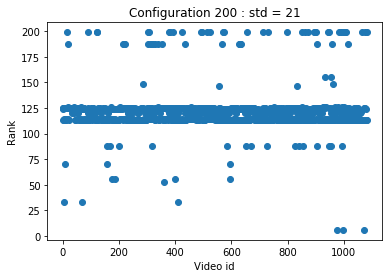

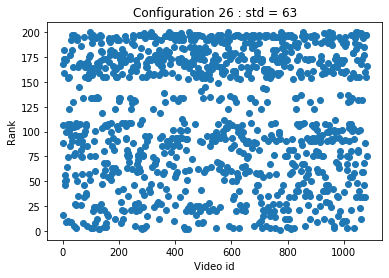

In [28]:
stds = [np.std(df.loc[i,:]) for i in range(len(df.index))]
print("Config min std : ", np.argmin(stds))
print("Config max std : ", np.argmax(stds))

print("Config med std : ", np.median(stds))

plt.scatter(range(len(df.columns)), df.loc[np.argmin(stds), :])
plt.ylabel("Rank")
plt.xlabel("Video id")
plt.title("Configuration "+str(np.argmin(stds))+" : std = "+str(int(np.round(np.min(stds)))))
plt.savefig("../../results/config_min_std_ranking.png")
plt.show()

plt.scatter(range(len(df.columns)), df.loc[np.argmax(stds), :])
plt.ylabel("Rank")
plt.xlabel("Video id")
plt.title("Configuration "+str(np.argmax(stds))+" : std = "+str(int(np.round(np.max(stds)))))
plt.savefig("../../results/config_max_std_ranking.png")
plt.show()

In [29]:
print(np.min(stds))
print(np.max(stds))

20.50548240798353
62.945701359293516


In [30]:
print(np.sum([1  for j in range(len(df.loc[np.argmin(stds),:])) 
              if df.loc[np.argmin(stds),:][j] > 105 and df.loc[np.argmin(stds),:][j] < 130])
      /len(df.loc[np.argmin(stds),:]))

0.9159741458910434


In [31]:
np.where(df.loc[np.argmin(stds),:] == np.min(df.loc[np.argmin(stds),:]))

(array([ 975,  997, 1073]),)

In [32]:
np.where(df.loc[np.argmax(stds),:] == np.max(df.loc[np.argmax(stds),:]))

(array([  98,  313,  378,  448,  588,  777,  856,  948, 1045, 1048]),)

In [33]:
pd.Series(df.loc[np.argmax(stds),:]).describe()

count    1083.000000
mean      116.357341
std        62.974782
min         1.000000
25%        62.000000
50%       109.000000
75%       173.000000
max       200.000000
Name: 26, dtype: float64

# RQ2

## RQ2.1 - Group of performances

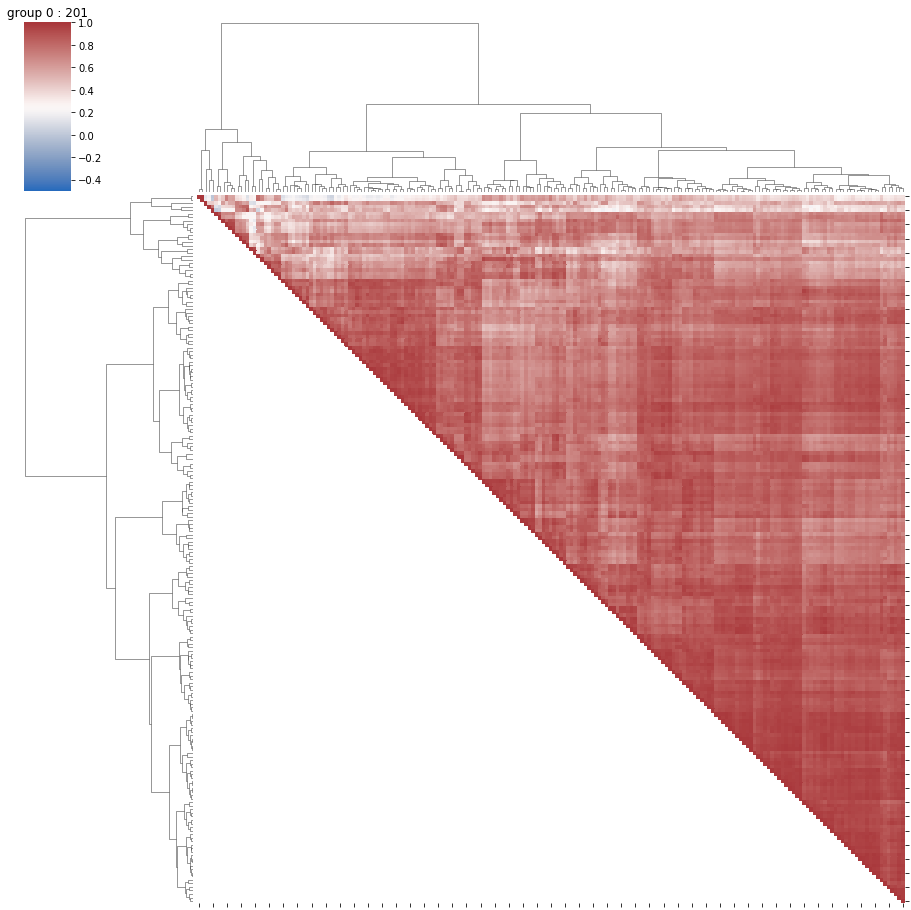

count    20100.000000
mean         0.775970
std          0.142496
min         -0.007185
25%          0.704894
50%          0.808535
75%          0.879485
max          0.997228
dtype: float64


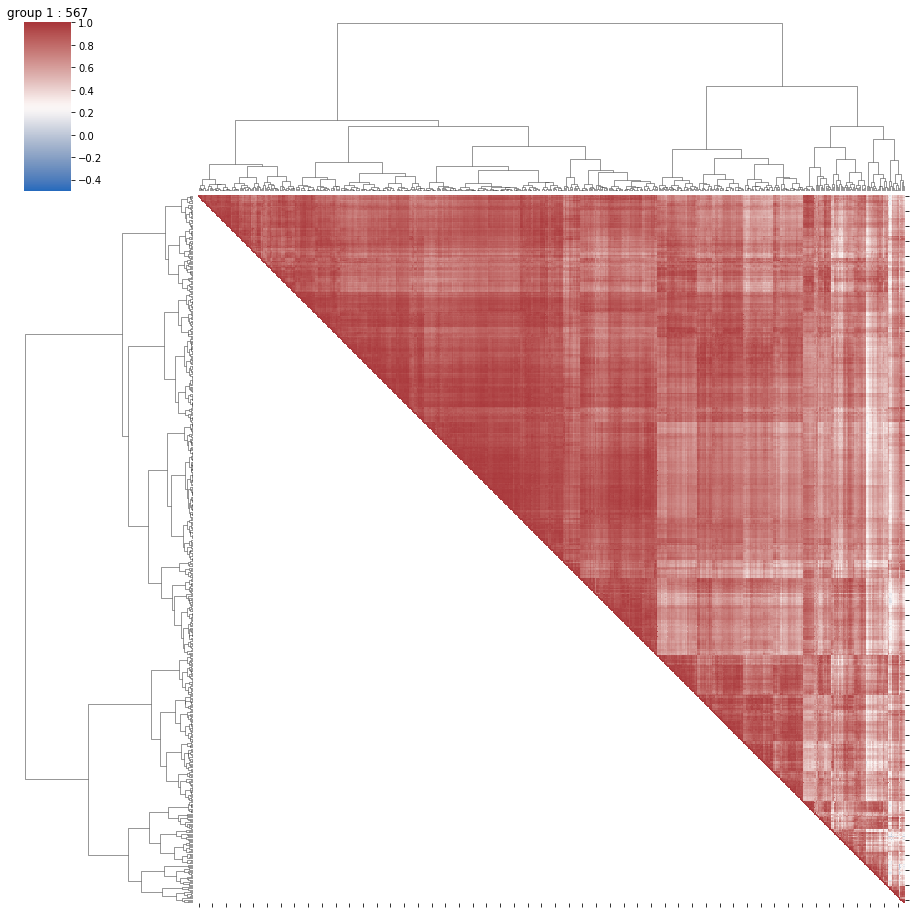

count    160461.000000
mean          0.771654
std           0.137068
min          -0.028942
25%           0.691684
50%           0.795087
75%           0.878146
max           0.996812
dtype: float64


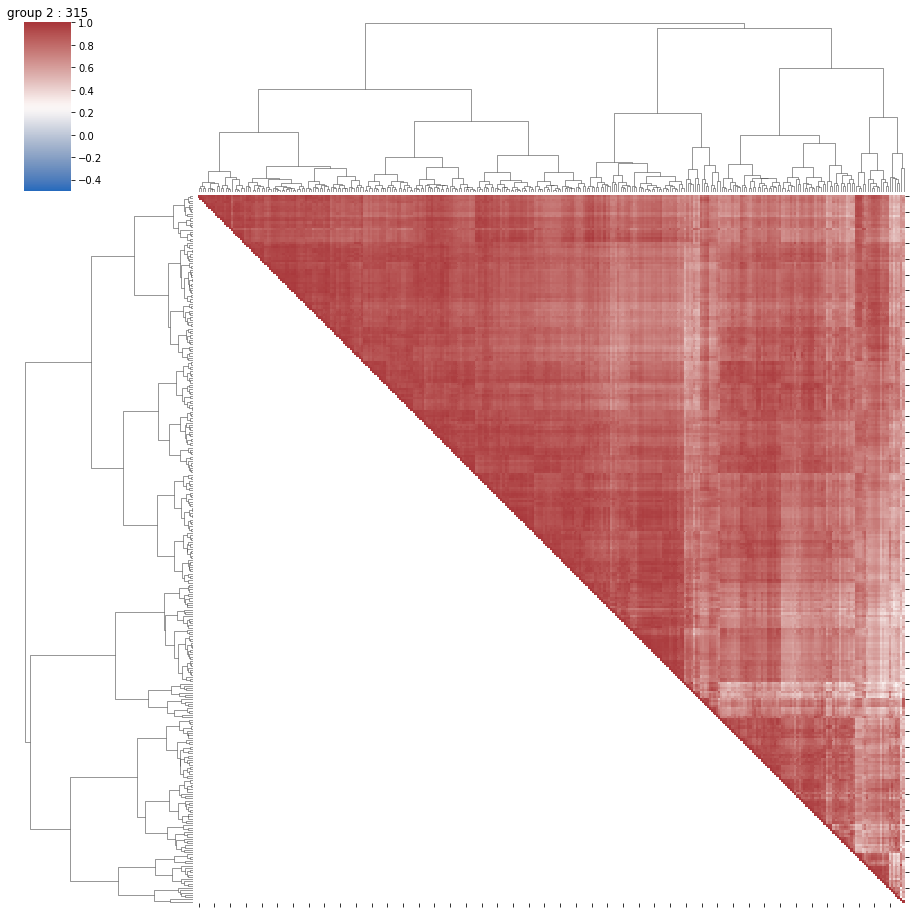

count    49455.000000
mean         0.809815
std          0.110026
min          0.196619
25%          0.747105
50%          0.830915
75%          0.894257
max          0.996081
dtype: float64


In [34]:
def plot_corr_matrix(corr, method = 'ward', title=''):

    df = pd.DataFrame(corr)
    
    links = linkage(df, method=method,)
    order = leaves_list(links)
    
    mask = np.zeros_like(corr, dtype=np.bool)
    
    for i in range(len(corr)):
        for j in range(len(corr)):
            if i>j:
                mask[order[i]][order[j]] = True
    
    g = sns.clustermap(df, cmap="vlag", mask=mask, method=method,
                   linewidths=0, figsize=(13, 13), vmin=-0.5)
    g.ax_heatmap.set_yticklabels([])
    g.ax_heatmap.set_xticklabels([])
    plt.title(title)
    plt.show()
    
    corrDescription = [corr[i][j] for i in range(len(corr)) for j in range(len(corr)) if i >j]
    return pd.Series(corrDescription).describe()

def plot_group(group_index):
    ind = np.array([k for k in range(len(corrSpearman)) if groups[k] == group_index], dtype=int)
    group = np.copy([[corrSpearman[k][j] for j in ind] for k in ind])
    print(plot_corr_matrix(group,title="group "+str(group_index)+" : "+str(len(group))))

for i in range(3):
    plot_group(i)

## Summary per group

In [35]:
meta = pd.read_csv("../../data/ugc_meta/all_features.csv").set_index('FILENAME')
meta['category']=[str(meta.index[i]).split('_')[0] for i in range(meta.shape[0])]
del meta['NOISE_DMOS']
meta = meta.fillna(0)
cat_tab = pd.Series(meta['category'].values).unique()
meta['video_category'] = [np.where(cat_tab==meta['category'][i])[0][0] for i in range(len(meta['category']))]
del meta['category']
for col in meta.columns:#[:len(meta.columns)-1]:
    inter = np.array(meta[col],float)
    meta[col] = (inter-np.mean(inter))/np.std(inter)
perf = pd.DataFrame({'FILENAME': np.array([v_names[k][:-4] for k in range(len(v_names))])[1:],
              'perf_group' : np.array([k for k in groups])[1:]}).set_index('FILENAME')
meta_perf = perf.join(meta)
meta_perf

,perf_group,SLEEQ_DMOS,BANDING_DMOS,WIDTH,HEIGHT,SPATIAL_COMPLEXITY,TEMPORAL_COMPLEXITY,CHUNK_COMPLEXITY_VARIATION,COLOR_COMPLEXITY,video_category
FILENAME,,,,,,,,,,
Animation_1080P-05f8,2,0.843640,0.742227,0.380890,0.330315,-0.147062,0.443113,2.546727,2.208462,-1.618994
Animation_1080P-0c4f,1,-0.656518,-0.377309,0.380890,0.330315,0.422696,-0.963894,1.055535,-1.232585,-1.618994
Animation_1080P-0cdf,2,-0.294941,-0.059125,0.380890,0.330315,-0.028411,0.429840,-0.102867,-0.448165,-1.618994
Animation_1080P-18f5,1,-0.479576,-0.377309,0.380890,0.330315,1.289667,-0.959469,-0.050889,0.193239,-1.618994
Animation_1080P-209f,1,6.282675,-0.377309,0.380890,0.330315,2.315231,-1.512538,-0.622865,-1.232585,-1.618994
...,...,...,...,...,...,...,...,...,...,...
Vlog_720P-561e,1,-0.679597,-0.377309,-0.241046,-0.334452,0.979531,-1.415198,-0.652628,0.457602,1.494285
Vlog_720P-5d08,2,-0.679597,-0.377309,-0.773579,-0.334452,3.258561,-0.304636,-0.437382,-0.157800,1.494285
Vlog_720P-60f8,1,0.443598,0.624381,-0.241046,-0.334452,0.234735,-0.043587,-0.364052,-0.149132,1.494285


In [36]:
meta_perf['str_video_cat'] = [str(meta_perf.index[i]).split('_')[0] for i in range(meta_perf.shape[0])]
total_cat = meta_perf.groupby('str_video_cat').count()['perf_group']
group_perf = np.array([gr for gr in groups])
group_perf

array([1, 2, 1, ..., 1, 0, 1])

In [37]:
def summary_group(id_group):
            
    id_list = [i for i in range(len(listVideo)) if group_perf[i]==id_group]
    v_names_group = [v_names[i][:-4] for i in range(len(v_names)) if i in id_list]
    listVideoGroup = [listVideo[i] for i in range(len(listVideo)) if i in id_list]
    
    print('Group '+str(id_group)+' : '+str(len(listVideoGroup))+' videos!')
    
    print('\n')

    # features importances
    boxplot_imp(compute_Importances(listVideoGroup), criteria = 'name', xlim= (0, 1),
               name ="../../results/boxplot_imp_group"+str(id_group)+".png")

    # features effects
    boxplot_imp(compute_poly(listVideoGroup), criteria = 'name', xlim = (-1, 1),
               name ="../../results/boxplot_effect_group"+str(id_group)+".png")

    print('\n')

    interest_var = ['cpu', 'etime', 'fps', 'kbs', 'size']

    for iv in interest_var:
        pred = [np.mean(lv[iv]) for lv in listVideoGroup]
        print('Mean '+iv+' in the group: '+str(np.round(np.mean(pred),1)))

    print('\n')

    # percentage of the videos present in the group par category

    meta_perf_group = meta_perf.query('perf_group=='+str(id_group))
    meta_perf_group['str_video_cat'] = [str(meta_perf_group.index[i]).split('_')[0] for i in range(meta_perf_group.shape[0])]
    val_group = meta_perf_group.groupby('str_video_cat').count()['perf_group']
    df_res_cat_group = pd.DataFrame({'val': val_group, 'total': total_cat})
    print(df_res_cat_group['val']/df_res_cat_group['total'])

    print('\n')

    # Mean of the videos of the group per properties

    for col in meta_perf_group.columns:
        if col not in ['str_video_cat', 'video_category']:
            print('Mean '+col+' : '+str(meta_perf_group[col].mean()))
            print('std '+col+' : '+str(meta_perf_group[col].std()))

    print('\n')

    corrGroup = np.array([corrSpearman[i][j] for i in range(len(corrSpearman)) if i in id_list 
                 for j in range(len(corrSpearman)) if j in id_list],float)

    print("Correlations intra-group: \n" + str(pd.Series(corrGroup).describe().iloc[[1,5]])+'\n')

In [38]:
summary_group(0)

Group 0 : 201 videos!




ValueError: Length of values does not match length of index

In [ ]:
summary_group(1)

In [ ]:
summary_group(2)

### Inter-group correlogram

In [ ]:
group_perf =groups
id_list_0 = [i for i in range(len(listVideo)) if group_perf[i]==0]
id_list_1 = [i for i in range(len(listVideo)) if group_perf[i]==1]
id_list_2 = [i for i in range(len(listVideo)) if group_perf[i]==2]

res = np.zeros(9).reshape(3,3)

tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res[0][1] = np.mean(tab)

for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res[0][2] = np.mean(tab)

for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res[1][2] = np.mean(tab)

print(res)

res_med = np.zeros(9).reshape(3,3)
 $$
tab = []
for id0 in id_list_0:
    for id1 in id_list_1:
        tab.append(corrSpearman[id0][id1])
res_med[0][1] = np.median(tab)

for id0 in id_list_0:
    for id2 in id_list_2:
        tab.append(corrSpearman[id0][id2])
res_med[0][2] = np.median(tab)

for id1 in id_list_1:
    for id2 in id_list_2:
        tab.append(corrSpearman[id1][id2])
res_med[1][2] = np.median(tab)

res_med

## RQ2.2 - Group classification

In [ ]:
if 'str_video_cat' in meta_perf.columns:
    del meta_perf['str_video_cat']

accuracy = []

nbLaunches =10
for i in range(nbLaunches):
    X = np.array(meta_perf[[k for k in meta_perf.columns if k !='perf_group']], float)
    y = np.array(meta_perf['perf_group'], float)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

    rf = RandomForestClassifier()
    rf.fit(X_train, y_train)
    y_pred = rf.predict(X_test)


    conf = pd.crosstab(y_pred, y_test)#, colnames=[1,2,3], rownames=[1,2,3])
    val = np.sum(np.diag(conf))/len(y_test)
    accuracy.append(val)
    print('Test accuracy : '+ str(val))
    conf.columns = pd.Int64Index([1,2,3], dtype='int64', name='Observed')
    conf.index = pd.Int64Index([1,2,3], dtype='int64', name='Predicted')
    conf
print(np.mean(accuracy))
conf

In [ ]:
meta_perf

In [ ]:
pd.DataFrame({'Random forest importance' : rf.feature_importances_,
              'name' : meta_perf.columns[1:]}).set_index('name')

In [ ]:
meta_perf.groupby(['perf_group']).mean()

## RQ2.1- Ranking

In [30]:
for i in range(len(v_names)):
    #i=0
    v = v_names[1][:-4]
    if v in meta_perf.index:
        meta_data = meta_perf.loc[v]
        vid = listVideo[i]
        sizes = vid[predDimension]
        listVideo[i]["order"] = sorted(range(len(sizes)), key=lambda k: sizes[k])
vid.groupby("cabac").mean()["order"]

cabac
0     95.812500
1    101.956204
Name: order, dtype: float64

In [31]:
list_properties = ['SLEEQ_DMOS', 'BANDING_DMOS', 'WIDTH', 'HEIGHT', 'SPATIAL_COMPLEXITY', 'TEMPORAL_COMPLEXITY', 
                   'CHUNK_COMPLEXITY_VARIATION', 'COLOR_COMPLEXITY']
listFeatures = ["cabac", "ref", "deblock", "analyse", "me", "subme", "mixed_ref", "me_range", "trellis", "8x8dct", "fast_pskip", "chroma_qp_offset", "bframes", "b_pyramid", "b_adapt", "direct", "weightb", "open_gop", "weightp", "scenecut", "rc_lookahead", "mbtree", "qpmax", "aq-mode"]

list_video_train, list_video_test = train_test_split(v_names, test_size=0.2)

vid = listVideo[0]

feature_labels = dict()

for lf in listFeatures:
    feature_labels[lf] = tuple(vid.groupby(lf).mean()["order"].index)

prop = dict()

for index_prop in range(len(list_properties)):
    prop_name = list_properties[index_prop]
    var =  meta_perf[prop_name]
    prop[prop_name] = [np.percentile(var, 25), np.median(var), np.percentile(var, 75)]

vid_prop = dict()

for i in range(len(v_names)):
    v = v_names[i][:-4]
    if v in meta_perf.index:
        vid = meta_perf.loc[v]
        prop_indexes = []
        for index_prop in range(len(list_properties)):
            prop_name = list_properties[index_prop]
            ref_quartile_prop = prop[prop_name]
            index_quartile = 0
            break_cond = False
            while index_quartile < 3 and not break_cond:
                if vid[prop_name] > ref_quartile_prop[index_quartile]:
                    index_quartile+=1
                else:
                    break_cond = True
            prop_indexes.append(index_quartile)
        #prop_indexes.append(v.split('_')[0])
        vid_prop[v] = prop_indexes 
#print(vid_prop)

tune_table = dict()

for p in range(len(list_properties)):
    for f in listFeatures:
        for p_index in range(4):
            list_video_pf = [tuple(listVideo[k].groupby(f).mean()["order"])
                           for k in range(len(v_names)) if v_names[k][:-4] in meta_perf.index 
                             and v_names[k] in list_video_train
                           and vid_prop[v_names[k][:-4]][p] == p_index]
            tune_table_element = []
            for j in range(len(list_video_pf[0])):
                tune_table_element.append(np.mean([k[j] for k in list_video_pf]))
            tune_table[(f, list_properties[p], p_index)] = tune_table_element
tune_table

{('cabac', 'SLEEQ_DMOS', 0): [98.49553571428571, 100.70281543274244],
 ('cabac', 'SLEEQ_DMOS', 1): [98.87413594470046, 100.52595109152679],
 ('cabac', 'SLEEQ_DMOS', 2): [99.18186358447488, 100.38219511382195],
 ('cabac', 'SLEEQ_DMOS', 3): [98.92225609756098, 100.50347160405907],
 ('ref', 'SLEEQ_DMOS', 0): [97.04982718894009,
  103.42725840336134,
  107.95818452380952,
  107.78370535714285,
  120.4747023809524,
  87.47792658730158,
  95.17463235294119],
 ('ref', 'SLEEQ_DMOS', 1): [99.83187156236063,
  100.23000813228516,
  105.857910906298,
  107.84493087557603,
  111.90937019969276,
  87.3394777265745,
  95.9449715370019],
 ('ref', 'SLEEQ_DMOS', 2): [100.1158491677714,
  101.07023905452593,
  104.62937595129377,
  104.37511415525115,
  113.7366818873668,
  87.06139015728057,
  97.69795863550898],
 ('ref', 'SLEEQ_DMOS', 3): [100.413217938631,
  101.58780487804879,
  104.0087804878049,
  104.98317073170733,
  107.81951219512194,
  88.71869918699187,
  96.47274031563845],
 ('deblock', 'SL

In [32]:
generated_config = []

for index_video in range(len(list_video_test)):
    video_test_name = list_video_test[index_video][:-4]
    chosen_features = ['']*len(listFeatures)
    for i in range(len(listFeatures)):
        f = listFeatures[i]
        res = np.zeros(len(feature_labels[f]))
        for j in range(len(list_properties)):
            p = list_properties[j]
            prop_val = vid_prop[video_test_name][j]
            index_vote = np.argmin(tune_table[(f, p, prop_val)])
            res[index_vote] += 1
        chosen_features[i] = feature_labels[f][np.argmax(res)]
    generated_config.append(tuple(chosen_features))

generated_config

[(0,
  8,
  '1:0:0',
  '0x3:0x113',
  'umh',
  9,
  0,
  24,
  2,
  1,
  0,
  0,
  0,
  '1',
  '2',
  'None',
  'None',
  'None',
  0,
  '0',
  '60',
  0,
  69,
  1),
 (0,
  8,
  '1:0:0',
  '0x3:0x133',
  'umh',
  9,
  0,
  24,
  2,
  1,
  0,
  0,
  0,
  '1',
  '2',
  'None',
  'None',
  'None',
  0,
  '0',
  '60',
  0,
  69,
  1),
 (0,
  8,
  '1:0:0',
  '0x3:0x133',
  'umh',
  9,
  0,
  24,
  2,
  1,
  0,
  0,
  0,
  '1',
  '2',
  'None',
  'None',
  'None',
  0,
  '0',
  '60',
  0,
  69,
  1),
 (0,
  8,
  '1:0:0',
  '0x3:0x113',
  'umh',
  9,
  0,
  24,
  2,
  1,
  0,
  0,
  0,
  '1',
  '2',
  'None',
  'None',
  'None',
  0,
  '0',
  '60',
  0,
  69,
  1),
 (0,
  8,
  '1:0:0',
  '0x3:0x133',
  'umh',
  9,
  0,
  24,
  2,
  1,
  0,
  0,
  0,
  '1',
  '2',
  'None',
  'None',
  'None',
  0,
  '0',
  '60',
  0,
  69,
  1),
 (0,
  8,
  '1:0:0',
  '0x3:0x133',
  'umh',
  9,
  0,
  24,
  2,
  1,
  0,
  0,
  0,
  '1',
  '2',
  'None',
  'None',
  'None',
  0,
  '0',
  '60',
  0,
  69,
  0)

In [33]:

vid = listVideo[0]

feature_labels = dict()

for lf in listFeatures:
    feature_labels[lf] = tuple(vid.groupby(lf).mean()["order"].index)
feature_labels

{'cabac': (0, 1),
 'ref': (1, 2, 3, 5, 7, 8, 16),
 'deblock': ('0:0:0', '1:0:0'),
 'analyse': ('0:0', '0x113:0x113', '0x3:0x113', '0x3:0x133', '0x3:0x3'),
 'me': ('dia', 'hex', 'tesa', 'umh'),
 'subme': (0, 1, 2, 4, 6, 7, 8, 9, 10, 11),
 'mixed_ref': (0, 1),
 'me_range': (16, 24),
 'trellis': (0, 1, 2),
 '8x8dct': (0, 1),
 'fast_pskip': (0, 1),
 'chroma_qp_offset': (-2, 0),
 'bframes': (0, 3, 8, 16),
 'b_pyramid': ('1', '2', 'None'),
 'b_adapt': ('1', '2', 'None'),
 'direct': ('None', 'auto', 'spatial'),
 'weightb': ('1', 'None'),
 'open_gop': ('0', 'None'),
 'weightp': (0, 1, 2),
 'scenecut': ('0', '40', 'None'),
 'rc_lookahead': ('10', '20', '30', '40', '50', '60', 'None'),
 'mbtree': (0, 1),
 'qpmax': (69,),
 'aq-mode': (0, 1)}

In [34]:
meta_perf.columns

Index(['perf_group', 'SLEEQ_DMOS', 'BANDING_DMOS', 'WIDTH', 'HEIGHT',
       'SPATIAL_COMPLEXITY', 'TEMPORAL_COMPLEXITY',
       'CHUNK_COMPLEXITY_VARIATION', 'COLOR_COMPLEXITY', 'video_category'],
      dtype='object')

## RQ2.3 - (Auto-)tune

In [ ]:
import tensorflow as tf
import tensorflow.keras as kr
print(tf.__version__)

In [ ]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
sb.set()

def get_y(x):
    return 10 + x*x

def sample_data(n=10000, scale=100):
    data = []

    x = scale*(np.random.random_sample((n,))-0.5)

    for i in range(n):
        yi = get_y(x[i])
        data.append([x[i], yi])

    return np.array(data)

def sample_Z(m, n):
    return np.random.uniform(-1., 1., size=[m, n])

def generator(Z,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Generator",reuse=reuse):
        h1 = tf.layers.dense(Z,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        out = tf.layers.dense(h2,2)

    return out

def discriminator(X,hsize=[16, 16],reuse=False):
    with tf.variable_scope("GAN/Discriminator",reuse=reuse):
        h1 = tf.layers.dense(X,hsize[0],activation=tf.nn.leaky_relu)
        h2 = tf.layers.dense(h1,hsize[1],activation=tf.nn.leaky_relu)
        h3 = tf.layers.dense(h2,2)
        out = tf.layers.dense(h3,1)

    return out, h3


X = tf.placeholder(tf.float32,[None,2])
Z = tf.placeholder(tf.float32,[None,2])

G_sample = generator(Z)
r_logits, r_rep = discriminator(X)
f_logits, g_rep = discriminator(G_sample,reuse=True)

disc_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=r_logits,labels=tf.ones_like(r_logits)) + tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.zeros_like(f_logits)))
gen_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=f_logits,labels=tf.ones_like(f_logits)))

gen_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Generator")
disc_vars = tf.get_collection(tf.GraphKeys.GLOBAL_VARIABLES,scope="GAN/Discriminator")

gen_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(gen_loss,var_list = gen_vars) # G Train step
disc_step = tf.train.RMSPropOptimizer(learning_rate=0.001).minimize(disc_loss,var_list = disc_vars) # D Train step



# sess = tf.Session(config=config)
sess = tf.Session()
tf.global_variables_initializer().run(session=sess)

batch_size = 256
nd_steps = 10
ng_steps = 10

x_plot = sample_data(n=batch_size)

f = open('loss_logs.csv','w')
f.write('Iteration,Discriminator Loss,Generator Loss\n')

for i in range(10001):
    X_batch = sample_data(n=batch_size)
    Z_batch = sample_Z(batch_size, 2)

    for _ in range(nd_steps):
        _, dloss = sess.run([disc_step, disc_loss], feed_dict={X: X_batch, Z: Z_batch})
    rrep_dstep, grep_dstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})

    for _ in range(ng_steps):
        _, gloss = sess.run([gen_step, gen_loss], feed_dict={Z: Z_batch})

    rrep_gstep, grep_gstep = sess.run([r_rep, g_rep], feed_dict={X: X_batch, Z: Z_batch})
    
    if i%1000 == 0:
        print("Iterations: %d\t Discriminator loss: %.4f\t Generator loss: %.4f"%(i,dloss,gloss))
        f.write("%d,%f,%f\n"%(i,dloss,gloss))

    if i%1000 == 0:
        plt.figure()
        g_plot = sess.run(G_sample, feed_dict={Z: Z_batch})
        xax = plt.scatter(x_plot[:,0], x_plot[:,1])
        gax = plt.scatter(g_plot[:,0],g_plot[:,1])

        plt.legend((xax,gax), ("Real Data","Generated Data"))
        plt.title('Samples at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../iteration/iteration_%d.png'%i)
        plt.close()

        plt.figure()
        rrd = plt.scatter(rrep_dstep[:,0], rrep_dstep[:,1], alpha=0.5)
        rrg = plt.scatter(rrep_gstep[:,0], rrep_gstep[:,1], alpha=0.5)
        grd = plt.scatter(grep_dstep[:,0], grep_dstep[:,1], alpha=0.5)
        grg = plt.scatter(grep_gstep[:,0], grep_gstep[:,1], alpha=0.5)


        plt.legend((rrd, rrg, grd, grg), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))
        plt.title('Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../iteration/feature_transform_%d.png'%i)
        plt.close()

        plt.figure()

        rrdc = plt.scatter(np.mean(rrep_dstep[:,0]), np.mean(rrep_dstep[:,1]),s=100, alpha=0.5)
        rrgc = plt.scatter(np.mean(rrep_gstep[:,0]), np.mean(rrep_gstep[:,1]),s=100, alpha=0.5)
        grdc = plt.scatter(np.mean(grep_dstep[:,0]), np.mean(grep_dstep[:,1]),s=100, alpha=0.5)
        grgc = plt.scatter(np.mean(grep_gstep[:,0]), np.mean(grep_gstep[:,1]),s=100, alpha=0.5)

        plt.legend((rrdc, rrgc, grdc, grgc), ("Real Data Before G step","Real Data After G step",
                               "Generated Data Before G step","Generated Data After G step"))

        plt.title('Centroid of Transformed Features at Iteration %d'%i)
        plt.tight_layout()
        plt.savefig('../iteration/feature_transform_centroid_%d.png'%i)
        plt.close()

f.close()

In [ ]:
import numpy as np
import time
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior() 

from tensorflow.examples.tutorials.mnist import input_data

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten, Reshape
from keras.layers import Conv2D, Conv2DTranspose, UpSampling2D
from keras.layers import LeakyReLU, Dropout
from keras.layers import BatchNormalization
from keras.optimizers import Adam, RMSprop

import matplotlib.pyplot as plt

class ElapsedTimer(object):
    def __init__(self):
        self.start_time = time.time()
    def elapsed(self,sec):
        if sec < 60:
            return str(sec) + " sec"
        elif sec < (60 * 60):
            return str(sec / 60) + " min"
        else:
            return str(sec / (60 * 60)) + " hr"
    def elapsed_time(self):
        print("Elapsed: %s " % self.elapsed(time.time() - self.start_time) )

class DCGAN(object):
    def __init__(self, img_rows=28, img_cols=28, channel=1):

        self.img_rows = img_rows
        self.img_cols = img_cols
        self.channel = channel
        self.D = None   # discriminator
        self.G = None   # generator
        self.AM = None  # adversarial model
        self.DM = None  # discriminator model

    # (W−F+2P)/S+1
    def discriminator(self):
        if self.D:
            return self.D
        self.D = Sequential()
        depth = 64
        dropout = 0.4
        # In: 28 x 28 x 1, depth = 1
        # Out: 14 x 14 x 1, depth=64
        input_shape = (self.img_rows, self.img_cols, self.channel)
        self.D.add(Conv2D(depth*1, 5, strides=2, input_shape=input_shape,\
            padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*2, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*4, 5, strides=2, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        self.D.add(Conv2D(depth*8, 5, strides=1, padding='same'))
        self.D.add(LeakyReLU(alpha=0.2))
        self.D.add(Dropout(dropout))

        # Out: 1-dim probability
        self.D.add(Flatten())
        self.D.add(Dense(1))
        self.D.add(Activation('sigmoid'))
        self.D.summary()
        return self.D

    def generator(self):
        if self.G:
            return self.G
        self.G = Sequential()
        dropout = 0.4
        depth = 64+64+64+64
        dim = 7
        # In: 100
        # Out: dim x dim x depth
        self.G.add(Dense(dim*dim*depth, input_dim=100))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))
        self.G.add(Reshape((dim, dim, depth)))
        self.G.add(Dropout(dropout))

        # In: dim x dim x depth
        # Out: 2*dim x 2*dim x depth/2
        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/2), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(UpSampling2D())
        self.G.add(Conv2DTranspose(int(depth/4), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        self.G.add(Conv2DTranspose(int(depth/8), 5, padding='same'))
        self.G.add(BatchNormalization(momentum=0.9))
        self.G.add(Activation('relu'))

        # Out: 28 x 28 x 1 grayscale image [0.0,1.0] per pix
        self.G.add(Conv2DTranspose(1, 5, padding='same'))
        self.G.add(Activation('sigmoid'))
        self.G.summary()
        return self.G

    def discriminator_model(self):
        if self.DM:
            return self.DM
        optimizer = RMSprop(lr=0.0002, decay=6e-8)
        self.DM = Sequential()
        self.DM.add(self.discriminator())
        self.DM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.DM

    def adversarial_model(self):
        if self.AM:
            return self.AM
        optimizer = RMSprop(lr=0.0001, decay=3e-8)
        self.AM = Sequential()
        self.AM.add(self.generator())
        self.AM.add(self.discriminator())
        self.AM.compile(loss='binary_crossentropy', optimizer=optimizer,\
            metrics=['accuracy'])
        return self.AM

class MNIST_DCGAN(object):
    def __init__(self):
        self.img_rows = 28
        self.img_cols = 28
        self.channel = 1

        self.x_train = input_data.read_data_sets("mnist",\
        	one_hot=True).train.images
        self.x_train = self.x_train.reshape(-1, self.img_rows,\
        	self.img_cols, 1).astype(np.float32)

        self.DCGAN = DCGAN()
        self.discriminator =  self.DCGAN.discriminator_model()
        self.adversarial = self.DCGAN.adversarial_model()
        self.generator = self.DCGAN.generator()

    def train(self, train_steps=2000, batch_size=256, save_interval=0):
        noise_input = None
        if save_interval>0:
            noise_input = np.random.uniform(-1.0, 1.0, size=[16, 100])
        for i in range(train_steps):
            images_train = self.x_train[np.random.randint(0,
                self.x_train.shape[0], size=batch_size), :, :, :]
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            images_fake = self.generator.predict(noise)
            x = np.concatenate((images_train, images_fake))
            y = np.ones([2*batch_size, 1])
            y[batch_size:, :] = 0
            d_loss = self.discriminator.train_on_batch(x, y)

            y = np.ones([batch_size, 1])
            noise = np.random.uniform(-1.0, 1.0, size=[batch_size, 100])
            a_loss = self.adversarial.train_on_batch(noise, y)
            log_mesg = "%d: [D loss: %f, acc: %f]" % (i, d_loss[0], d_loss[1])
            log_mesg = "%s  [A loss: %f, acc: %f]" % (log_mesg, a_loss[0], a_loss[1])
            print(log_mesg)
            if save_interval>0:
                if (i+1)%save_interval==0:
                    self.plot_images(save2file=True, samples=noise_input.shape[0],\
                        noise=noise_input, step=(i+1))

    def plot_images(self, save2file=False, fake=True, samples=16, noise=None, step=0):
        filename = 'mnist.png'
        if fake:
            if noise is None:
                noise = np.random.uniform(-1.0, 1.0, size=[samples, 100])
            else:
                filename = "mnist_%d.png" % step
            images = self.generator.predict(noise)
        else:
            i = np.random.randint(0, self.x_train.shape[0], samples)
            images = self.x_train[i, :, :, :]

        plt.figure(figsize=(10,10))
        for i in range(images.shape[0]):
            plt.subplot(4, 4, i+1)
            image = images[i, :, :, :]
            image = np.reshape(image, [self.img_rows, self.img_cols])
            plt.imshow(image, cmap='gray')
            plt.axis('off')
        plt.tight_layout()
        if save2file:
            plt.savefig(filename)
            plt.close('all')
        else:
            plt.show()

mnist_dcgan = MNIST_DCGAN()
timer = ElapsedTimer()
mnist_dcgan.train(train_steps=10000, batch_size=256, save_interval=500)
timer.elapsed_time()
mnist_dcgan.plot_images(fake=True)
mnist_dcgan.plot_images(fake=False, save2file=True)